In [128]:
import pandas as pd
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 50)
pd.options.display.float_format = '{:.2f}'.format


import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gapminder import gapminder 

import datetime
from datetime import datetime as dt
import glob
import os

In [129]:
from pathlib import Path
current_dir = Path.cwd()
current_dir

raw_data_dir = current_dir / 'raw_data'
viz_folder_dir = current_dir/'viz_folder'

In [130]:
df = pd.read_parquet(raw_data_dir/'cash_jordan.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   video_id                    1148 non-null   object 
 1   full_title                  1148 non-null   object 
 2   full_description            1148 non-null   object 
 3   publishedAt                 1148 non-null   object 
 4   video_defaultLanguage       0 non-null      float64
 5   channel_id                  1148 non-null   object 
 6   channel_title               1148 non-null   object 
 7   video_defaultAudioLanguage  1148 non-null   object 
 8   video_categoryId            1148 non-null   object 
 9   video_duration              1148 non-null   object 
 10  video_caption               1148 non-null   object 
 11  video_licensedContent       1148 non-null   bool   
 12  video_viewCount             1148 non-null   object 
 13  video_likeCount             1148 

In [131]:
# Filter out columns containing the word "count"
count_columns = df.columns[df.columns.str.contains('count', case=False)]

# Convert the values to numeric type
df[count_columns] = df[count_columns].apply(pd.to_numeric)

In [132]:
# Extract the year, month and date datetime info and store in a new colum 'publishedDate'
df['publishedDate'] = pd.to_datetime(df['publishedAt']).dt.strftime("%Y-%m-%d")

# Extract the year and month datetime info and store in a new column 'publishedMonth'
df['publishedMonth'] = pd.to_datetime(df['publishedAt']).dt.strftime("%Y-%m")

# Convert the 'publishedAt' column to datetime objects for further datetime operations
df['publishedAt'] = pd.to_datetime(df['publishedAt'])


<Axes: xlabel='publishedMonth'>

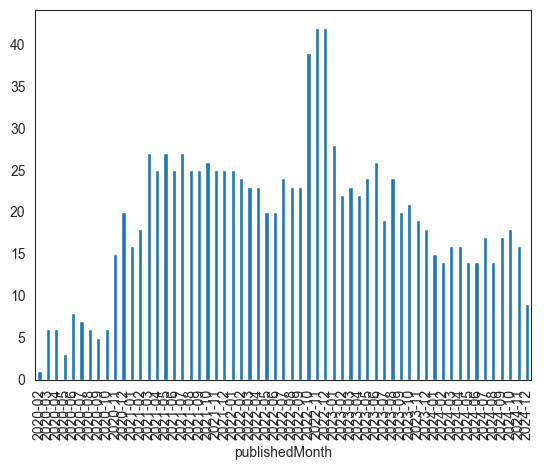

In [133]:
# Examine the overall distribution the dataset
df['publishedMonth'].value_counts(dropna=False).sort_index().plot(kind='bar')

In [134]:
import re 

# Create a function using regular expression to filter out the first paragraph of a chunck of text.
def find_first_paragraph(text):
    first_paragraph = re.search(r'(.+?)(?:\n\s*\n|$)', text, re.DOTALL)
    return first_paragraph.group(1).strip() if first_paragraph else None

In [135]:
df['description_first_paragraph'] = df.full_description.apply(find_first_paragraph)
df['description_first_paragraph'].tail()

1143                                                         Amazing Penthouse with Gorgeous Views of lower Manhattan from the Private Roof Deck.  This apt is in a great locaiton but it has 1 drawback you will see in the video. Hope you like this one - I'd def live here, but would you rent a place like this? Comment below and let me know!
1144           $2000 Challenge! See what will a 2k Budget get you if you want to live in Manhattan!  2 Tours of 2 apartments in the mid $2000's, in downtown Manhattan so you can see what it would be like to live here!  Also, we compare them to the photos posted on listing websites so you can see how these apartments look IRL vs on an App.
1145                                                                              Do you think this 2 bedroom is underpriced or do you think Manhattan is a total ripoff no matter what you end up with? I thought this Lower East Side place was a good find for the $$$ but im curious to hear what you think, so leave a co

In [136]:
# Combine all text fields into a single column 'title+description_first_paragraph'
df['title+description_first_paragraph'] = df.full_title + " | " + df['description_first_paragraph']
df['title+description_first_paragraph']

0                                                                                                                                                                                                                                                                The Drone Invasion Just Hit NYC... | Residents of NYC are now reporting drone sightings which match the description of those from nearby NJ... yet when the NYPD deploys resources to track them down, they somehow come up empty handed.
1       Terrified Migrants Flee NYC… as 25 Shelters Close | NYC has announced the sudden closure of 25 shelters, panicking residents who thought they'd come to a sanctuary city.  Speaking of which, Mayor Adams is looking for ways of rolling back sanctuary policies that stop NYPD from communicating with ICE to get dangerous individuals off the streets.  Will these polices make the city safer for law abiding immigrants and asylum seekers? Or are critics right in saying this is a mistake?
2                 

In [137]:
import spacy
import nltk
nltk.download('wordnet')
from nltk import bigrams, trigrams
nlp = spacy.load('en_core_web_lg')
stopwords = list(nlp.Defaults.stop_words) 

from nltk.tokenize import word_tokenize, TweetTokenizer
import contractions
import emoji
import re
from spacy.matcher import PhraseMatcher


url_pattern = re.compile(r'\bhttps?://\S+\b|\bwww\.\S+\b')
email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
mention_pattern = re.compile(r'^(@\w+\s+)+')

def remove_urls(text: str) -> str:
    """Remove URLs from text."""
    return url_pattern.sub('', text)

def remove_emails(text: str) -> str:
    """Remove email addresses from text."""
    return email_pattern.sub('', text)

def remove_last_hashtags(text: str) -> str:
    """Remove hashtags at the end of the text."""
    tokens = [token.lower() for token in TweetTokenizer().tokenize(text)]
    while tokens and tokens[-1].startswith("#"):
        tokens.pop()
    return ' '.join(tokens).strip()

def remove_extra_stops(doc, extra_stops=None):
    if not extra_stops:
        return doc

    matcher = PhraseMatcher(nlp.vocab, attr="LOWER")
    patterns = [nlp.make_doc(phrase.lower()) for phrase in extra_stops]
    matcher.add("EXTRA_STOPS", patterns)

    matches = matcher(doc)
    tokens_to_remove = set()
    for _, start, end in matches:
        tokens_to_remove.update(range(start, end))

    filtered_tokens = [token for i, token in enumerate(doc) if i not in tokens_to_remove]

    return filtered_tokens


def clean_it_all_up (text, extra_stops):
    # remove emails
    text = remove_emails(text)
    # remove urls
    text = remove_urls(text)
    # remove last hashtags
    text = remove_last_hashtags(text)
    text = emoji.replace_emoji(text)
    text = contractions.fix(text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\n', ' ', text)
    doc = nlp(text)
    filtered_tokens = remove_extra_stops(doc, extra_stops)
    lemmatized_tokens = []
    for token in filtered_tokens:
        if (
            token.text.lower() not in stopwords
            and token.pos_ not in {"AUX", "ADP", "CONJ", "CCONJ", "DET", "INTJ",
                                   "PART", "PUNCT", "SCONJ", "SYM", "X", "SPACE"}
        ):
            lemmatized_tokens.append(token.lemma_.lower())

    return lemmatized_tokens 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/keenansmacbookairm3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [138]:
s = "i love New York basketball."
extra_stops = ['nyc', 'new york', 'new york city', 'brooklyn', 'bronx', 'manhattan']

# Convert s to lowercase to handle case-insensitive replacement
s_lower = s.lower()

for stop in extra_stops:
    s_lower = s_lower.replace(stop, '')

# Optional: strip extra spaces
s_cleaned = ' '.join(s_lower.split())

print(s_cleaned)


i love basketball.


In [139]:
# A functiont returning
def date_selection(start_date, end_date):
    start_date = datetime.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = end_date = datetime.datetime.strptime(end_date, "%Y-%m-%d")
    date_list = []
    current_date = start_date
    date_list.append(current_date.strftime('%Y-%m-%d'))
    while current_date < end_date:
        next_date = current_date + datetime.timedelta(days=1)
        next_date = next_date
        if next_date >= end_date:
            next_date = end_date
        date_list.append(next_date.strftime('%Y-%m-%d'))
        current_date = next_date
    return date_list


In [140]:
def ngram_generator(dataframe, date_column, text_column, start_date, end_date, num, extra_stops, top_n=None):
    date_list = date_selection(start_date, end_date)

    # collect all tokens as a list of tokens, not a string
    all_tokens = []
    for text in dataframe[dataframe[date_column].isin(date_list)][text_column]:
        if isinstance(text, str):
            tokens = clean_it_all_up(text, extra_stops)
            all_tokens.extend(tokens)
    
    if num == 1:
        ngram = pd.Series(all_tokens).value_counts()
    elif num == 2:
        ngram = pd.Series(list(bigrams(all_tokens))).value_counts()
    elif num == 3:
        ngram = pd.Series(list(trigrams(all_tokens))).value_counts()
    else:
        raise ValueError('Invalid number. Must choose between 1, 2, or 3.')

    ngram = ngram[ngram > 1]
    if top_n:
        ngram = ngram.head(top_n)
    return ngram


In [141]:
dataframe = df
text_column= 'description_first_paragraph'
date_column = 'publishedDate'
start_date ='2020-01-01'
end_date ='2025-02-01'
num = 2
extra_stops= ['nyc', 'new york', 'new york city', 'brooklyn', 'bronx', 'manhattan']
top_n=50

top_bigram = ngram_generator(dataframe, date_column,text_column, start_date, end_date, num, extra_stops, top_n)
top_bigram

(let, know)                244
(apartment, tour)          215
(know, think)              183
(luxury, apartment)        169
(tour, let)                141
(roof, deck)                71
(affordable, apartment)     67
(tiny, apartment)           66
(new, yorker)               66
(cheap, apartment)          65
(apartment, rent)           64
(2, floor)                  59
(2, bedroom)                56
(check, apartment)          55
(apartment, hunting)        54
(brand, new)                49
(cool, apartment)           46
(2, bath)                   46
(asylum, seeker)            44
(central, park)             42
(upper, west)               40
(loft, apartment)           39
(super, cool)               38
(luxury, building)          34
(small, apartment)          33
(live, apartment)           33
(3, bedroom)                32
(think, apartment)          30
(cafe, shop)                30
(1, bedroom)                30
(apartment, let)            30
(check, luxury)             28
(rent, a

In [142]:
dataframe = df
text_column= 'description_first_paragraph'
date_column = 'publishedDate'
start_date ='2023-09-01'
end_date ='2025-02-01'
num = 2
extra_stops= ['nyc', 'new york', 'new york city', 'brooklyn', 'bronx', 'manhattan']
top_n=20

top_bigram = ngram_generator(dataframe, date_column,text_column, start_date, end_date, num, extra_stops, top_n)
top_bigram

(asylum, seeker)          44
(new, yorker)             17
(asylum, crisis)          10
(sanctuary, city)          9
(law, abide)               8
(shelter, asylum)          7
(shelter, system)          7
(mayor, eric)              5
(eric, adams)              5
(seek, asylum)             5
(leave, city)              5
(recent, report)           4
(national, guard)          4
(journalistic, report)     4
(central, park)            4
(report, indicate)         4
(year, old)                4
(abide, asylum)            4
(seeker, come)             4
(perfect, apartment)       4
Name: count, dtype: int64

In [143]:
df.full_description.str.len().describe()

count   1148.00
mean    1116.89
std      667.13
min        0.00
25%      774.00
50%      903.00
75%     1317.50
max     4049.00
Name: full_description, dtype: float64

In [144]:
df[df.video_viewCount == df.video_viewCount.max()]

,video_id,full_title,full_description,publishedAt,video_defaultLanguage,channel_id,channel_title,video_defaultAudioLanguage,video_categoryId,video_duration,video_caption,video_licensedContent,video_viewCount,video_likeCount,video_commentCount,publishedDate,publishedMonth,description_first_paragraph,title+description_first_paragraph
209,AnqUoAEg6f4,NYC is Building Anti-Homeless Streets…,"“Hostile Architecture” has many purposes, but should it be used against NYC’s most vulnerable? There are examples of this type of design all over the city, some by private companies, and others by the city itself.\n\nRuby’s Saga - Ryan James Carr // Working For the Man - Aesyme\n\nNeed Music? Get Epidemic Sound: https://www.epidemicsound.com/referral/18oofi\n\n**Everything used to make this video**\n\n[Camera] https://amzn.to/3VBWywO\n[Mic] https://amzn.to/3ptHhz3\n[Lens] https://amzn.to/3MZGmmF\n[Backpack] https://amzn.to/45pHoP1\n[Handheld Tripod] https://amzn.to/3iUp3Ex \n[Full Size Tripod] https://amzn.to/3cp2sty \n[Lights] https://amzn.to/3izy3ic \n\nGreat news! If you make a purchase from any link above, my channel earns a small affiliate commission from the site.",2023-11-12 14:39:00+00:00,NaN,UCrwbBzP11NhxRUCRKx_BgoQ,Cash Jordan,en-US,22,PT14M27S,false,True,18265175,214876,51926,2023-11-12,2023-11,"“Hostile Architecture” has many purposes, but should it be used against NYC’s most vulnerable? There are examples of this type of design all over the city, some by private companies, and others by the city itself.","NYC is Building Anti-Homeless Streets… | “Hostile Architecture” has many purposes, but should it be used against NYC’s most vulnerable? There are examples of this type of design all over the city, some by private companies, and others by the city itself."


In [225]:
apartment_condo = ['apartment', 'condo', 'rent', 'house']
migrant_crime = ['crime', 'criminal', 'migrant', 'homeless', 'gang', 'riot', 'shelter', 'asylum']

# Slice out rows containing only apartment-related keywords and migrant/crime/homeless-related keywords
apartment_counts = df[df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)].publishedMonth.value_counts(dropna=False).sort_index()
migrant_counts = df[df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)].publishedMonth.value_counts(dropna=False).sort_index()

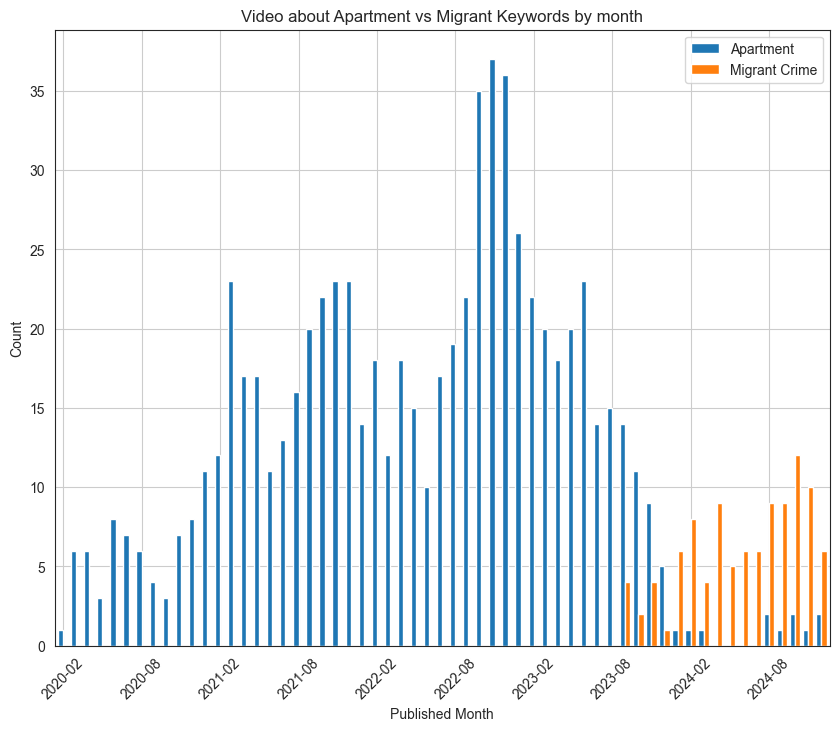

In [226]:
# Combine into one DataFrame
count_df = pd.DataFrame({
    'Apartment': apartment_counts,
    'Migrant Crime': migrant_counts
}).fillna(0)

count_df.plot(
    kind='bar',
    figsize=(10,8), 
    width=0.8
    )

unique_months = sorted(df['publishedMonth'].unique())

plt.xticks(
    range(0, len(unique_months), 6), 
    labels=[unique_months[i] for i in range(0, len(unique_months), 6)],
    rotation=45
    )
              
plt.title('Video about Apartment vs Migrant Keywords by month')
plt.xlabel('Published Month')
plt.ylabel('Count')
plt.grid(True)
plt.show()

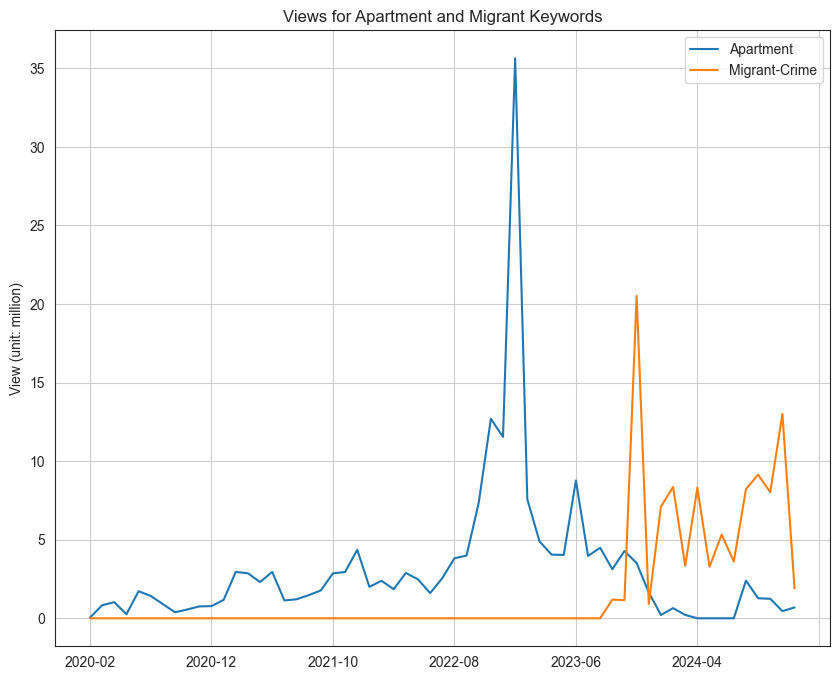

In [227]:
sns.set_style('white')

apartment_view = df[df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)].groupby('publishedMonth').video_viewCount.sum() /1000000
migrant_view = df[df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)].groupby('publishedMonth').video_viewCount.sum() /1000000

# Combine into one DataFrame
view_df = pd.DataFrame({
    'Apartment': apartment_view,
    'Migrant-Crime': migrant_view
}).fillna(0)  # Fill missing months with 0

# Plot
view_df.plot(kind='line',
             figsize=(10,8) 
             )
plt.title('Views for Apartment and Migrant Keywords')
plt.xlabel('')
plt.ylabel('View (unit: million)')
plt.grid(True)
plt.show()


In [228]:
# Calculate the upper and lower limits for outlier detection
upper_limit = df.video_viewCount.mean() + 3 * df.video_viewCount.std()
lower_limit = df.video_viewCount.mean() -3 * df.video_viewCount.std()
print(f"The upper limit is {upper_limit}")
print(f"The lower limit is {lower_limit}")

The upper limit is 3035160.5187401483
The lower limit is -2331434.53093527


In [229]:
outliers_df = df[df.video_viewCount > upper_limit]
normal_df = df[df.video_viewCount < upper_limit]
outliers_df.shape

(12, 19)

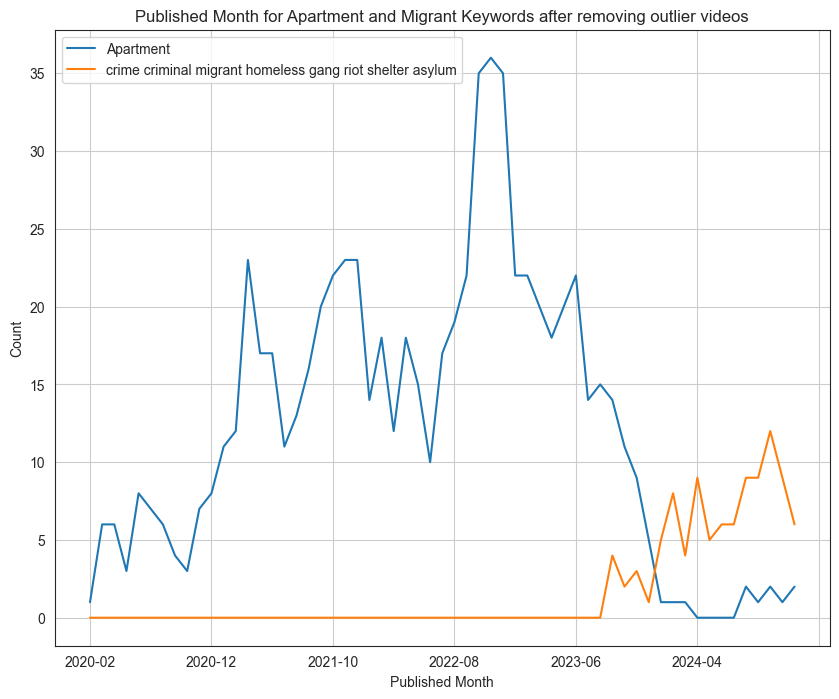

In [230]:
# Get the value counts for 'apartment' and 'migrant' keywords
apartment_counts = normal_df[normal_df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)].publishedMonth.value_counts(dropna=False).sort_index()
migrant_counts = normal_df[normal_df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)].publishedMonth.value_counts(dropna=False).sort_index()

# Combine into one DataFrame
count_df = pd.DataFrame({
    'Apartment': apartment_counts,
    ' '.join(migrant_crime): migrant_counts
}).fillna(0) 

# Plot
count_df.plot(kind='line',
              figsize=(10,8) 
             )
              
plt.title('Published Month for Apartment and Migrant Keywords after removing outlier videos')
plt.xlabel('Published Month')
plt.ylabel('Count')
plt.grid(True)
plt.show()

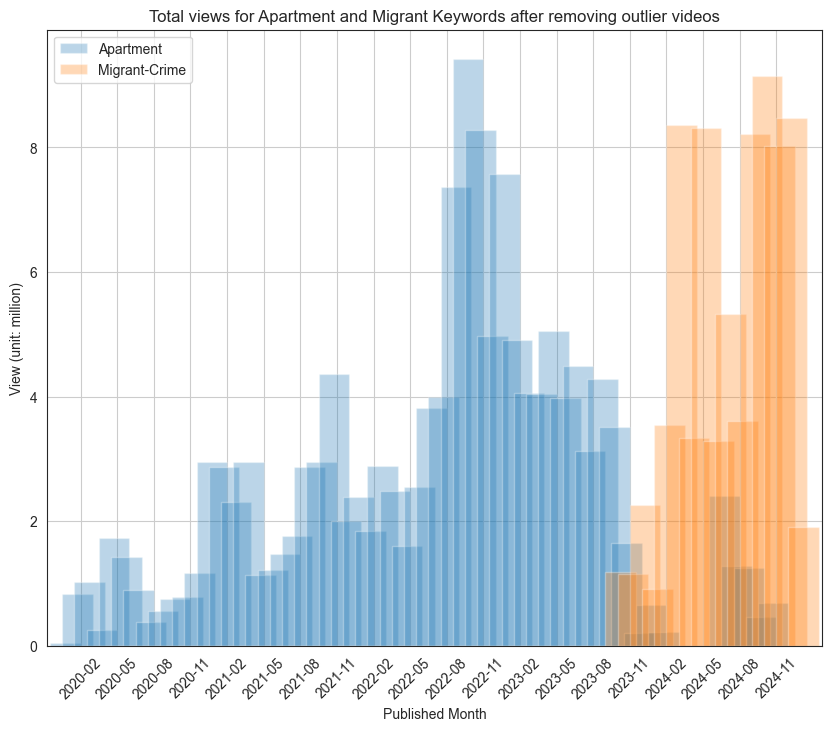

In [231]:
sns.set_style('white')

apartment_view = normal_df[normal_df.full_title.str.contains('|'.join(apartment_condo), case=False, na=False)].groupby('publishedMonth').video_viewCount.sum() /1000000
migrant_view = normal_df[normal_df.full_title.str.contains('|'.join(migrant_crime), case=False, na=False)].groupby('publishedMonth').video_viewCount.sum() /1000000

# Combine into one DataFrame
view_df = pd.DataFrame({
    'Apartment': apartment_view,
    'Migrant-Crime': migrant_view
}).fillna(0)  # Fill missing months with 0

# Plot
view_df.plot(kind='bar',
             figsize=(10,8),
             width=5,
             alpha=0.3
             )

unique_months = sorted(normal_df['publishedMonth'].unique())

plt.xticks(
    range(0, len(unique_months), 3), 
    labels=[unique_months[i] for i in range(0, len(unique_months), 3)],
    rotation=45
)
plt.title('Total views for Apartment and Migrant Keywords after removing outlier videos')
plt.xlabel('Published Month')
plt.ylabel('View (unit: million)')
plt.grid(True)
plt.show()

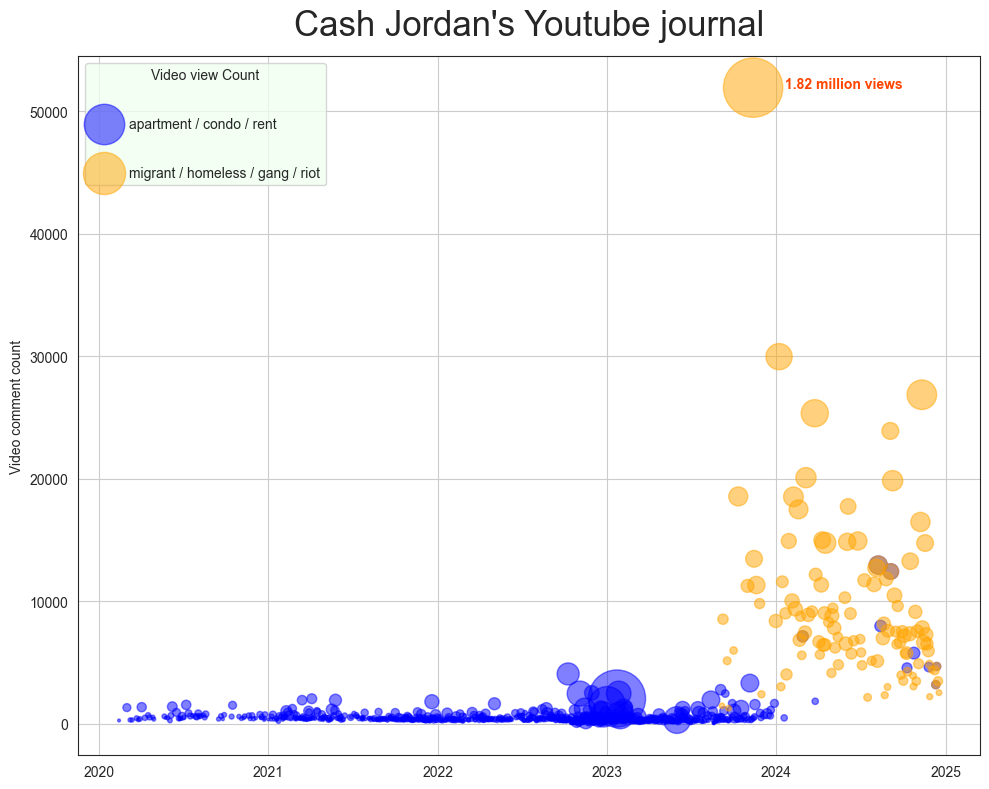

In [232]:
sns.set_style('white')
plt.figure(figsize=(10, 8))
plt.scatter(
    apartment_data['publishedAt'],
    apartment_data['video_commentCount'],
    s=apartment_data['video_viewCount'] /10000,
    alpha=0.5,
    label="Apartment Data",
    color='blue'
)

max_migrant_views_index = migrant_data['video_viewCount'].idxmax()
max_migrant_views = migrant_data.loc[max_migrant_views_index]

plt.scatter(
    migrant_data['publishedAt'],
    migrant_data['video_commentCount'],
    s=migrant_data['video_viewCount'] /10000,
    alpha=0.5,
    label="Migrant Data",
    color='orange'
)

plt.annotate(
    f"1.82 million views",
    (max_migrant_views['publishedAt'], max_migrant_views['video_commentCount']),
    textcoords="offset points",
    xytext=(65, 0), 
    ha='center',
    fontsize=10,
    color='orangered',
    fontweight='bold'
)

plt.title("Cash Jordan's Youtube journal", fontsize=25, pad=15)
plt.xlabel('')
plt.ylabel('Video comment count')
plt.legend(
    ['apartment / condo / rent',
     'migrant / homeless / gang / riot'], 
    loc='upper left',
    labelspacing=2.5,
    title="Video view Count",
    facecolor='honeydew'
    )

plt.grid(True)
plt.tight_layout()
plt.show()

In [233]:
# The historic subscriber data is from the Internet Archive
jordan_subs_data = {
    "20191211": "0K",
    "20221121143109": "369K",
    "20230316025651": "430K",
    "20230330055520": "440K",
    "20230420220605": "467K",
    "20230531115930": "501K",
    "20230816052553": "536K",
    "20230828220218": "544K",
    "20231022004202": "577K",
    "20231108084225": "591K",
    "20231129061320": "648K",
    "20231225214904": "679K",
    "20240126104302": "728K",
    "20240227091435": "783K",
    "20240402183343": "858K",
    "20240503000634": "901K",
    "20240702151547": "957K",
    "20240825191335": "1000K",
    "20240915174042": "1020K",
    "20241217193431": "1100K", 
    "20250314120438": "1260K"
}

jordan_subs_df = pd.DataFrame(
    list(jordan_subs_data.items()),
    columns=["date", "subscriber_count"]
)
jordan_subs_df.head()

,date,subscriber_count
0,20191211,0K
1,20221121143109,369K
2,20230316025651,430K
3,20230330055520,440K
4,20230420220605,467K


In [234]:
from datetime import datetime as dt
jordan_subs_df.date = pd.to_datetime(jordan_subs_df["date"], format="mixed")
jordan_subs_df.date  = jordan_subs_df.date.dt.date
jordan_subs_df.subscriber_count = jordan_subs_df.subscriber_count.str.replace('K', '')
jordan_subs_df.subscriber_count = pd.to_numeric(jordan_subs_df.subscriber_count)

jordan_subs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   date              21 non-null     object
 1   subscriber_count  21 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes


In [235]:
apartment_data['publishedAt'] = pd.to_datetime(apartment_data['publishedAt']).dt.tz_localize(None)
migrant_data['publishedAt'] = pd.to_datetime(migrant_data['publishedAt']).dt.tz_localize(None)
jordan_subs_df['date'] = pd.to_datetime(jordan_subs_df['date']).dt.tz_localize(None)

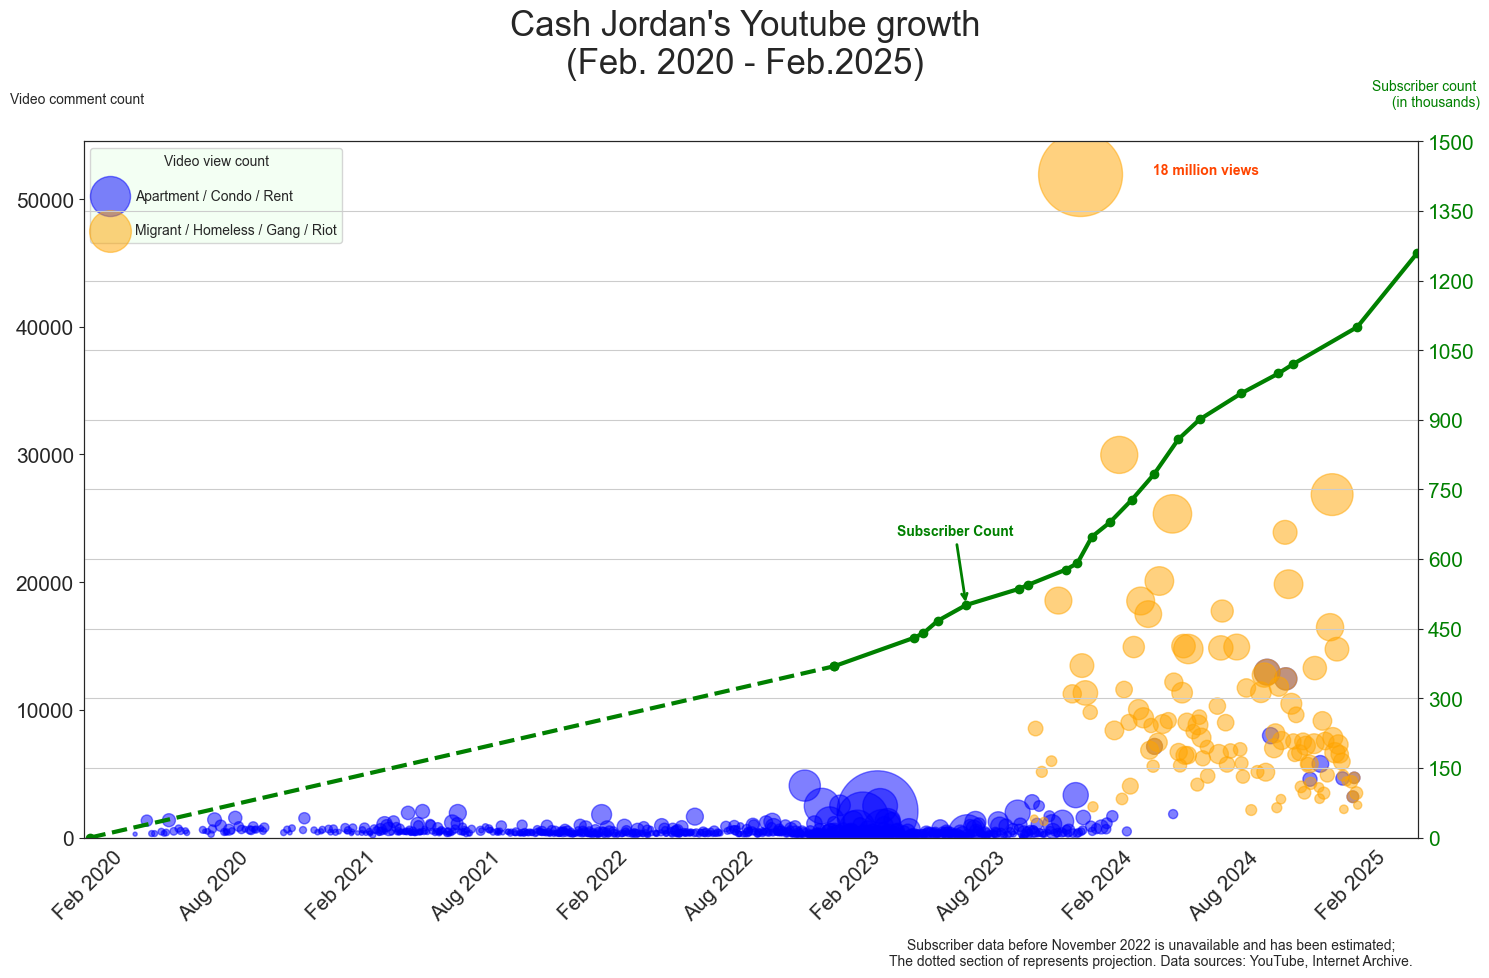

In [ ]:
# This chunck of codes creates a twin-axis chart

fig, ax1 = plt.subplots(figsize=(15, 10))

# Scatter plot for apartment data
ax1.scatter(
    apartment_data['publishedAt'],
    apartment_data['video_commentCount'],
    s=apartment_data['video_viewCount'] / 5000,  # Size adjusted by video views
    alpha=0.5,
    label="Apartment Data",
    color='blue'
)

# Scatter plot for migrant data
ax1.scatter(
    migrant_data['publishedAt'],
    migrant_data['video_commentCount'],
    s=migrant_data['video_viewCount'] / 5000,  # Size adjusted by video views
    alpha=0.5,
    label="Migrant Data",
    color='orange'
)

# Set labels for left y-axis
ax1.set_xlabel('')
ax1.set_ylabel('Video comment count',
               fontsize=10,
               rotation='horizontal',
               ha='left',
               position=(1, 1.05) 
               )

# Create second y-axis (ax2) for subscriber count

ax2 = ax1.twinx()

"""ax2.plot(
    jordan_subs_df['date'], 
    jordan_subs_df['subscriber_count'], 
    color='green',
    linewidth=3,
    marker='o'
)"""

ax2.plot(
    jordan_subs_df['date'][:2], 
    jordan_subs_df['subscriber_count'][:2], 
    color='green',
    ls='--',
    linewidth=3,
    marker='o'
)

ax2.plot(
    jordan_subs_df['date'][1:], 
    jordan_subs_df['subscriber_count'][1:], 
    color='green',
    ls='-',
    linewidth=3,
    marker='o'
)

ax2.set_ylabel('Subscriber count \n (in thousands)', 
               color='green',
               fontsize=10,
               rotation='horizontal',
               ha='right',
               position=(1, 1.09) 
)
ax2.set_ylim(0, 1500)  
ax2.set_yticks(range(0, 1501, 150))  
ax2.tick_params(axis='y', labelcolor='green')


# Set both y-axes to start from 0
ax1.set_ylim(bottom=0)  # Make sure left y-axis starts from 0
ax2.set_ylim(0, 1500)   # Ensure right y-axis starts at 0 and ends at 1500

# Ensure that the x-axis is the same for both axes
ax1.set_xlim(datetime.datetime(2019, 12, 1), datetime.datetime(2025, 3, 15))

# Format the x-axis to display months
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Formatter for month and year

plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

max_migrant_views_index = migrant_data['video_viewCount'].idxmax()
max_migrant_views = migrant_data.loc[max_migrant_views_index]

ax1.annotate(
    f"18 million views",
    (max_migrant_views['publishedAt'], max_migrant_views['video_commentCount']),
    textcoords="offset points",
    xytext=(90, 0), 
    ha='center',
    fontsize=10,
    color='orangered',
    fontweight='bold'
)

mid_index = len(jordan_subs_df) // 4
mid_date = jordan_subs_df['date'].iloc[mid_index]
mid_subscriber_count = jordan_subs_df['subscriber_count'].iloc[mid_index]

# Annotation for the subscriber count line (at the midpoint)
ax2.annotate(
    "Subscriber Count", 
    xy=(mid_date, mid_subscriber_count),  # Point to the midpoint of the line plot
    xytext=(-50, 50),  # Position of the text relative to the midpoint
    textcoords="offset points", 
    arrowprops=dict(arrowstyle="->", color="green", lw=2),  # Arrow pointing to the line
    fontsize=10, 
    color="green", 
    fontweight="bold"
)

# Set custom legends
ax1.legend(
    ['Apartment / Condo / Rent', 
     'Migrant / Homeless / Gang / Riot'], 
     markerscale=0.7,
    loc='upper left',
    labelspacing=1.5,
    title="Video view count",
    facecolor='honeydew',
    fontsize=10, 
    title_fontsize=10
)
ax2.annotate(
    "Subscriber data before November 2022 is unavailable and has been estimated;\n" \
    "The dotted section of represents projection. Data sources: YouTube, Internet Archive.",
    xy=(0.8, -0.18), 
    xycoords='axes fraction',  
    ha='center',  
    fontsize=10,
    wrap=True
)

plt.grid(True)
plt.subplots_adjust(bottom=0.15) 
plt.suptitle("Cash Jordan's Youtube growth\n(Feb. 2020 - Feb.2025)", fontsize=25)
plt.tight_layout()
plt.savefig(f"{viz_folder_dir}/cash_jordan_youtube_metrics.jpeg", dpi=600)
plt.show()